<a href="https://colab.research.google.com/github/seeedata/Kaggle_Study/blob/main/231106%20Deep%20Learning%20for%20Tseries%20Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The goal of this notebook is to develop and compare different approaches to time-series problems.

https://www.kaggle.com/code/dimitreoliveira/deep-learning-for-time-series-forecasting/notebook

# Dependencies

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import optimizers
from keras.utils import plot_model
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPooling1D
from keras.layers import Dense, LSTM, RepeatVector, TimeDistributed, Flatten
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
!pip install chart_studio
import chart_studio as py
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
import plotly.offline as pyo

%matplotlib inline
warnings.filterwarnings("ignore")
init_notebook_mode(connected=True)

import tensorflow as tf
tf.random.set_seed(1)
from numpy.random import seed
seed(1)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 461.0 kB/s eta 0:00:00


 # Loading data

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/4주차/train.csv', parse_dates=['date'])
test = pd.read_csv('/content/drive/MyDrive/KUCC/23-2 캐글 필사 스터디/4주차/test.csv', parse_dates=['date'])

# Train set

In [ ]:
train.describe()

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


In [ ]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


# Time period of the train dataset

In [ ]:
print('Min date from train set: %s' % train['date'].min().date())
print('Max date from train set: %s' % train['date'].max().date())

Min date from train set: 2013-01-01
Max date from train set: 2017-12-31


In [ ]:
lag_size = (test['date'].max().date() - train['date'].max().date()).days
print('Max date from train set: %s' % train['date'].max().date())
print('Max date from test set: %s' % test['date'].max().date())
print('Forecast lag size', lag_size)

Max date from train set: 2017-12-31
Max date from test set: 2018-03-31
Forecast lag size 90


lag size 90 means the amount of day that need to be forecast.

# Basic EDA

To explore the time series data, first we need to aggregate the sales by day.

In [ ]:
daily_sales = train.groupby('date', as_index=False)['sales'].sum()
store_daily_sales = train.groupby(['store', 'date'], as_index=False)['sales'].sum()
item_daily_sales = train.groupby(['item', 'date'], as_index=False)['sales'].sum()
print(daily_sales, '\n', store_daily_sales, '\n', item_daily_sales)

           date  sales
0    2013-01-01  13696
1    2013-01-02  13678
2    2013-01-03  14488
3    2013-01-04  15677
4    2013-01-05  16237
...         ...    ...
1821 2017-12-27  20378
1822 2017-12-28  21885
1823 2017-12-29  23535
1824 2017-12-30  24988
1825 2017-12-31  26420

[1826 rows x 2 columns] 
        store       date  sales
0          1 2013-01-01   1316
1          1 2013-01-02   1264
2          1 2013-01-03   1305
3          1 2013-01-04   1452
4          1 2013-01-05   1499
...      ...        ...    ...
18255     10 2017-12-27   2221
18256     10 2017-12-28   2429
18257     10 2017-12-29   2687
18258     10 2017-12-30   2742
18259     10 2017-12-31   2939

[18260 rows x 3 columns] 
        item       date  sales
0         1 2013-01-01    133
1         1 2013-01-02     99
2         1 2013-01-03    127
3         1 2013-01-04    145
4         1 2013-01-05    149
...     ...        ...    ...
91295    50 2017-12-27    511
91296    50 2017-12-28    587
91297    50 2017-12-29    5

## Overall daily sales

In [ ]:
import seaborn as sns

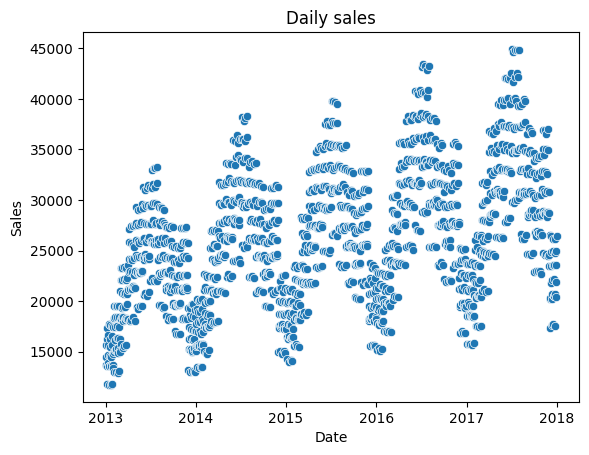

In [ ]:
sns.scatterplot(x=daily_sales['date'], y=daily_sales['sales'])
plt.title('Daily sales')
plt.xlabel('Date')
plt.ylabel('Sales');

## Daily sales by store

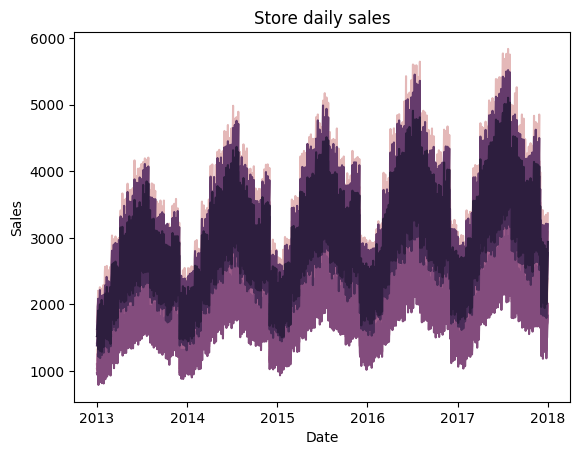

In [ ]:
sns.lineplot(x=store_daily_sales['date'], y=store_daily_sales['sales'], hue=store_daily_sales['store'], legend=False)
plt.title('Store daily sales')
plt.xlabel('Date')
plt.ylabel('Sales');

## Daily sales by item

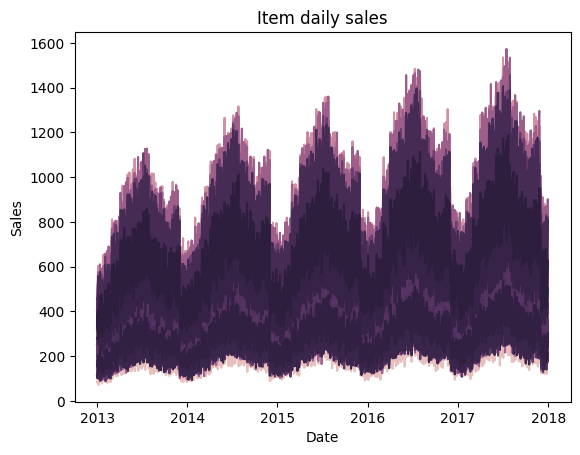

In [ ]:
sns.lineplot(x=item_daily_sales['date'], y=item_daily_sales['sales'], hue=item_daily_sales['item'], legend=False)
plt.title('Item daily sales')
plt.xlabel('Date')
plt.ylabel('Sales');

Sub-sample train set to get only the last year of data and reduce training time.

In [ ]:
train = train[(train['date'] >= '2017-01-01')]

In [ ]:
train.head()

,date,store,item,sales
1461,2017-01-01,1,1,19
1462,2017-01-02,1,1,15
1463,2017-01-03,1,1,10
1464,2017-01-04,1,1,16
1465,2017-01-05,1,1,14


# Rearrange dataset so we can apply shift methods

In [ ]:
train_gp = train.sort_values('date').groupby(['item', 'store', 'date'], as_index=False)
train_gp = train_gp.agg({'sales':['mean']})
train_gp.columns = ['item', 'store', 'date', 'sales']
train_gp.head()

,item,store,date,sales
0,1,1,2017-01-01,19.0
1,1,1,2017-01-02,15.0
2,1,1,2017-01-03,10.0
3,1,1,2017-01-04,16.0
4,1,1,2017-01-05,14.0


# Transform the data into a time series problem

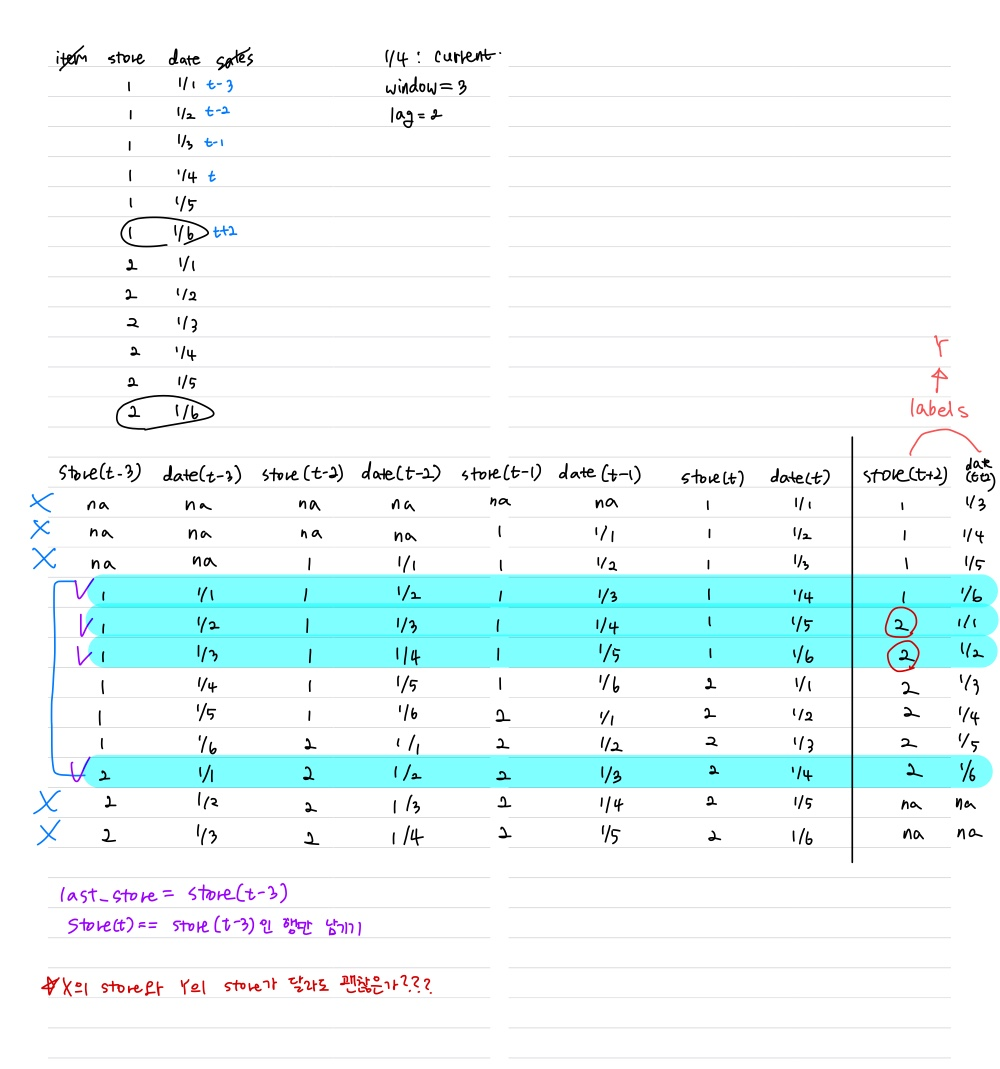

In [ ]:
#시계열 데이터를 지도 학습을 위한 형태로 변환.
#window: 입력 시퀀스의 길이 (과거 관측값 수)
#lag: 목표 시점에서의 시차 (미래 관측값 수)
#dropnan: NaN 값을 가진 행을 삭제할지 여부
def series_to_supervised(data, window=1, lag=1, dropnan=True):
    cols, names = list(), list()

    #Input sequence(t-n, ..., t-1)를 생성
    for i in range(window, 0, -1):
        cols.append(data.shift(i))  #data.shift(i): data의 각 열을 i 시점 앞으로 이동시킨 결과를 반환
        names += [('%s(t-%d)' % (col, i)) for col in data.columns]

    #Current timestep(t=0. 현재 시점의 데이터)를 생성
    cols.append(data)
    names += [('%s(t)' % (col)) for col in data.columns]

    #Target timestep(t=lag. 미래)
    cols.append(data.shift(-lag))
    names += [('%s(t+%d)' % (col, lag)) for col in data.columns]

    #Put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names

    #Drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)

    return agg

We will use the current timestep and the last 29 to forecast 90 days ahead.

In [ ]:
window = 29
lag = lag_size
series = series_to_supervised(train_gp.drop('date', axis=1), window=window, lag=lag)
series

,item(t-29),store(t-29),sales(t-29),item(t-28),store(t-28),sales(t-28),item(t-27),store(t-27),sales(t-27),item(t-26),...,sales(t-2),item(t-1),store(t-1),sales(t-1),item(t),store(t),sales(t),item(t+90),store(t+90),sales(t+90)
29,1.0,1.0,19.0,1.0,1.0,15.0,1.0,1.0,10.0,1.0,...,16.0,1.0,1.0,24.0,1,1,9.0,1.0,1.0,33.0
30,1.0,1.0,15.0,1.0,1.0,10.0,1.0,1.0,16.0,1.0,...,24.0,1.0,1.0,9.0,1,1,17.0,1.0,1.0,15.0
31,1.0,1.0,10.0,1.0,1.0,16.0,1.0,1.0,14.0,1.0,...,9.0,1.0,1.0,17.0,1,1,15.0,1.0,1.0,21.0
32,1.0,1.0,16.0,1.0,1.0,14.0,1.0,1.0,24.0,1.0,...,17.0,1.0,1.0,15.0,1,1,17.0,1.0,1.0,29.0
33,1.0,1.0,14.0,1.0,1.0,24.0,1.0,1.0,14.0,1.0,...,15.0,1.0,1.0,17.0,1,1,24.0,1.0,1.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182405,50.0,10.0,79.0,50.0,10.0,89.0,50.0,10.0,96.0,50.0,...,79.0,50.0,10.0,80.0,50,10,82.0,50.0,10.0,63.0
182406,50.0,10.0,89.0,50.0,10.0,96.0,50.0,10.0,92.0,50.0,...,80.0,50.0,10.0,82.0,50,10,90.0,50.0,10.0,59.0
182407,50.0,10.0,96.0,50.0,10.0,92.0,50.0,10.0,102.0,50.0,...,82.0,50.0,10.0,90.0,50,10,103.0,50.0,10.0,74.0
182408,50.0,10.0,92.0,50.0,10.0,102.0,50.0,10.0,60.0,50.0,...,90.0,50.0,10.0,103.0,50,10,99.0,50.0,10.0,62.0


Error: Runtime no longer has a reference to this dataframe, please re-run this cell and try again.


Drop rows with different item or store values than the shifted columns

In [ ]:
last_item = 'item(t-%d)' % window
last_store = 'store(t-%d)' % window
series = series[(series['store(t)'] == series[last_store])]
series = series[(series['item(t)'] == series[last_item])]

Remove unwanted columns

In [ ]:
#미래 시점 item, store 열 삭제
columns_to_drop = [('%s(t+%d)' % (col, lag)) for col in ['item', 'store']]
#과거 시점 item, store 열 삭제
for i in range(window, 0, -1):
    columns_to_drop += [('%s(t-%d)' % (col, i)) for col in ['item', 'store']]
series.drop(columns_to_drop, axis=1, inplace=True)
#현재 시점 item, store 열 삭제
series.drop(['item(t)', 'store(t)'], axis=1, inplace=True)

In [ ]:
series

,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t),sales(t+90)
29,19.0,15.0,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,...,21.0,9.0,18.0,14.0,13.0,10.0,16.0,24.0,9.0,33.0
30,15.0,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,...,9.0,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0
31,10.0,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,...,18.0,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0,21.0
32,16.0,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,...,14.0,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17.0,29.0
33,14.0,24.0,14.0,20.0,18.0,11.0,14.0,17.0,7.0,16.0,...,13.0,10.0,16.0,24.0,9.0,17.0,15.0,17.0,24.0,19.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182405,79.0,89.0,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,...,72.0,89.0,97.0,97.0,99.0,63.0,79.0,80.0,82.0,63.0
182406,89.0,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,...,89.0,97.0,97.0,99.0,63.0,79.0,80.0,82.0,90.0,59.0
182407,96.0,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,96.0,...,97.0,97.0,99.0,63.0,79.0,80.0,82.0,90.0,103.0,74.0
182408,92.0,102.0,60.0,81.0,79.0,78.0,97.0,93.0,96.0,74.0,...,97.0,99.0,63.0,79.0,80.0,82.0,90.0,103.0,99.0,62.0


# Train/validation split

In [ ]:
#y 생성 및 drop
labels_col = 'sales(t+%d)' % lag_size
labels = series[labels_col]
series = series.drop(labels_col, axis=1)

X_train, X_valid, Y_train, Y_valid = train_test_split(series, labels.values, test_size=0.4, random_state=0)
print('Train set shape', X_train.shape)
print('Validation set shape', X_valid.shape)
X_train.head()

Train set shape (100746, 30)
Validation set shape (67164, 30)


,sales(t-29),sales(t-28),sales(t-27),sales(t-26),sales(t-25),sales(t-24),sales(t-23),sales(t-22),sales(t-21),sales(t-20),...,sales(t-9),sales(t-8),sales(t-7),sales(t-6),sales(t-5),sales(t-4),sales(t-3),sales(t-2),sales(t-1),sales(t)
18801,97.0,111.0,90.0,115.0,123.0,70.0,99.0,74.0,107.0,108.0,...,85.0,95.0,123.0,109.0,127.0,132.0,87.0,101.0,102.0,114.0
160385,38.0,43.0,43.0,55.0,47.0,51.0,38.0,41.0,37.0,59.0,...,41.0,38.0,38.0,53.0,53.0,45.0,44.0,24.0,30.0,37.0
73123,55.0,45.0,41.0,46.0,47.0,36.0,30.0,46.0,41.0,42.0,...,38.0,36.0,40.0,50.0,44.0,44.0,40.0,38.0,50.0,49.0
90428,139.0,157.0,85.0,99.0,136.0,110.0,121.0,123.0,147.0,91.0,...,130.0,128.0,128.0,95.0,116.0,110.0,117.0,118.0,129.0,132.0
167151,86.0,58.0,88.0,87.0,114.0,113.0,64.0,76.0,87.0,81.0,...,55.0,66.0,59.0,53.0,63.0,59.0,77.0,39.0,56.0,62.0


# MLP for Time Series Forecasting
- First we will use a Multilayer Perceptron model or MLP model, here our model will have input features equal to the window size.

- The thing with MLP models is that the model don't take the input as sequenced data, so for the model, it is just receiving inputs and don't treat them as sequenced data, that may be a problem since the model won't see the data with the sequence patter that it has.

- Input shape **[samples, timesteps]**.

In [ ]:
epochs = 30
batch = 256
lr = 0.0003
adam = optimizers.Adam(lr)

In [ ]:
model_mlp = Sequential()
model_mlp.add(Dense(100, activation='relu', input_dim=X_train.shape[1]))  #input_dim=X_train.shape[1]: 입력 데이터의 특성 수
model_mlp.add(Dense(1))
model_mlp.compile(loss='mse', optimizer=adam)
model_mlp.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 100)               3100      
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
Total params: 3201 (12.50 KB)
Trainable params: 3201 (12.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
#X_train에 .values를 붙여 pandas DataFrame을 Numpy array로 변환
mlp_history = model_mlp.fit(X_train.values, Y_train, validation_data=(X_valid.values, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
3149/3149 - 13s - loss: 427.8631 - val_loss: 384.0638 - 13s/epoch - 4ms/step
Epoch 2/30
3149/3149 - 11s - loss: 375.6253 - val_loss: 370.1478 - 11s/epoch - 3ms/step
Epoch 3/30
3149/3149 - 19s - loss: 362.3816 - val_loss: 376.8849 - 19s/epoch - 6ms/step
Epoch 4/30
3149/3149 - 15s - loss: 358.0251 - val_loss: 381.3990 - 15s/epoch - 5ms/step
Epoch 5/30
3149/3149 - 18s - loss: 355.8036 - val_loss: 357.9651 - 18s/epoch - 6ms/step
Epoch 6/30
3149/3149 - 14s - loss: 353.2609 - val_loss: 353.0311 - 14s/epoch - 5ms/step
Epoch 7/30
3149/3149 - 16s - loss: 351.7050 - val_loss: 357.0250 - 16s/epoch - 5ms/step
Epoch 8/30
3149/3149 - 15s - loss: 350.3812 - val_loss: 348.5691 - 15s/epoch - 5ms/step
Epoch 9/30
3149/3149 - 13s - loss: 349.5102 - val_loss: 353.9797 - 13s/epoch - 4ms/step
Epoch 10/30
3149/3149 - 13s - loss: 348.3660 - val_loss: 350.1314 - 13s/epoch - 4ms/step
Epoch 11/30
3149/3149 - 12s - loss: 347.5472 - val_loss: 347.4041 - 12s/epoch - 4ms/step
Epoch 12/30
3149/3149 - 15s - 

# CNN for Time Series Forecasting

- For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.

- The convolutional layer should be able to identify patterns between the timesteps.

- Input shape **[samples, timesteps, features]**.

**Data preprocess**

- Reshape from [samples, timesteps] into [samples, timesteps, features].

- This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
X_train_series = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_valid_series = X_valid.values.reshape((X_valid.shape[0], X_valid.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (100746, 30, 1)
Validation set shape (67164, 30, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
adam = optimizers.Adam(learning_rate=0.003)
model_cnn.compile(optimizer=adam, loss='mean_squared_error')
model_cnn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 29, 64)            192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 14, 64)            0         
 D)                                                              
                                                                 
 flatten (Flatten)           (None, 896)               0         
                                                                 
 dense_4 (Dense)             (None, 50)                44850     
                                                                 
 dense_5 (Dense)             (None, 1)                 51        
                                                                 
Total params: 45093 (176.14 KB)
Trainable params: 45093 (176.14 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
cnn_history = model_cnn.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
3149/3149 - 20s - loss: 418.2208 - val_loss: 410.9084 - 20s/epoch - 6ms/step
Epoch 2/30
3149/3149 - 14s - loss: 392.7334 - val_loss: 384.2880 - 14s/epoch - 4ms/step
Epoch 3/30
3149/3149 - 14s - loss: 375.3821 - val_loss: 369.3681 - 14s/epoch - 4ms/step
Epoch 4/30
3149/3149 - 13s - loss: 371.2596 - val_loss: 419.0666 - 13s/epoch - 4ms/step
Epoch 5/30
3149/3149 - 13s - loss: 368.8807 - val_loss: 363.9409 - 13s/epoch - 4ms/step
Epoch 6/30
3149/3149 - 13s - loss: 367.1578 - val_loss: 365.7966 - 13s/epoch - 4ms/step
Epoch 7/30
3149/3149 - 13s - loss: 365.0593 - val_loss: 372.5630 - 13s/epoch - 4ms/step
Epoch 8/30
3149/3149 - 13s - loss: 363.1405 - val_loss: 358.1073 - 13s/epoch - 4ms/step
Epoch 9/30
3149/3149 - 13s - loss: 363.4031 - val_loss: 355.9862 - 13s/epoch - 4ms/step
Epoch 10/30
3149/3149 - 13s - loss: 361.5981 - val_loss: 354.2549 - 13s/epoch - 4ms/step
Epoch 11/30
3149/3149 - 13s - loss: 360.8027 - val_loss: 355.2213 - 13s/epoch - 4ms/step
Epoch 12/30
3149/3149 - 13s - 

# LSTM for Time Series Forecasting

- Now the LSTM model actually sees the input data as a sequence, so it's able to learn patterns from sequenced data (assuming it exists) better than the other ones, especially patterns from long sequences.
- Input shape **[samples, timesteps, features]**.

In [ ]:
model_lstm = Sequential()
model_lstm.add(LSTM(50, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_lstm.add(Dense(1))
adam = optimizers.Adam(learning_rate=0.003)
model_lstm.compile(optimizer=adam, loss='mean_squared_error')
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dense_6 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10451 (40.82 KB)
Trainable params: 10451 (40.82 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
lstm_history = model_lstm.fit(X_train_series, Y_train, validation_data=(X_valid_series, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
3149/3149 - 163s - loss: 511.7792 - val_loss: 468.0004 - 163s/epoch - 52ms/step
Epoch 2/30
3149/3149 - 158s - loss: 452.6285 - val_loss: 448.7323 - 158s/epoch - 50ms/step
Epoch 3/30
3149/3149 - 158s - loss: 429.1357 - val_loss: 421.3010 - 158s/epoch - 50ms/step
Epoch 4/30
3149/3149 - 165s - loss: 431.6845 - val_loss: 445.6841 - 165s/epoch - 52ms/step
Epoch 5/30
3149/3149 - 157s - loss: 419.0378 - val_loss: 404.5223 - 157s/epoch - 50ms/step
Epoch 6/30
3149/3149 - 156s - loss: 427.8570 - val_loss: 429.7621 - 156s/epoch - 50ms/step
Epoch 7/30
3149/3149 - 166s - loss: 435.1741 - val_loss: 460.6007 - 166s/epoch - 53ms/step
Epoch 8/30
3149/3149 - 159s - loss: 459.5209 - val_loss: 440.8168 - 159s/epoch - 51ms/step
Epoch 9/30
3149/3149 - 162s - loss: 433.9810 - val_loss: 423.1295 - 162s/epoch - 52ms/step
Epoch 10/30
3149/3149 - 195s - loss: 418.2345 - val_loss: 406.9353 - 195s/epoch - 62ms/step
Epoch 11/30
3149/3149 - 183s - loss: 423.0680 - val_loss: 447.2958 - 183s/epoch - 58ms/st

# CNN-LSTM for Time Series Forecasting

- Input shape **[samples, subsequences, timesteps, features]**.

- "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."

- "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."

- "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

**Data preprocess**
- Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [ ]:
subsequences = 2  #각 sample을 나눌 subsequence의 수 => 2
timesteps = X_train_series.shape[1] // subsequences  #subsequence당 포함할 timestep 수 => 15
X_train_series_sub = X_train_series.reshape((X_train_series.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = X_valid_series.reshape((X_valid_series.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

Train set shape (100746, 2, 15, 1)
Validation set shape (67164, 2, 15, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(50, activation='relu'))
model_cnn_lstm.add(Dense(1))
adam = optimizers.Adam(learning_rate=0.003)
model_cnn_lstm.compile(optimizer=adam, loss='mean_squared_error')

input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])에서 None이 사용된 이유

- 입력 데이터의 하위 시퀀스의 길이가 다를 수 있으므로 None을 사용하여 모델이 다양한 입력 시퀀스 길이에 유연하게 대응할 수 있게 한다.

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, Y_train, validation_data=(X_valid_series_sub, Y_valid), epochs=epochs, verbose=2)

Epoch 1/30
3149/3149 - 34s - loss: 420.5696 - val_loss: 410.7342 - 34s/epoch - 11ms/step
Epoch 2/30
3149/3149 - 32s - loss: 400.9043 - val_loss: 391.4612 - 32s/epoch - 10ms/step
Epoch 3/30
3149/3149 - 36s - loss: 398.7805 - val_loss: 391.6155 - 36s/epoch - 11ms/step
Epoch 4/30
3149/3149 - 42s - loss: 392.7349 - val_loss: 416.7055 - 42s/epoch - 13ms/step
Epoch 5/30
3149/3149 - 44s - loss: 385.7165 - val_loss: 371.8603 - 44s/epoch - 14ms/step
Epoch 6/30
3149/3149 - 45s - loss: 376.8786 - val_loss: 374.1419 - 45s/epoch - 14ms/step
Epoch 7/30
3149/3149 - 32s - loss: 372.4600 - val_loss: 371.0996 - 32s/epoch - 10ms/step
Epoch 8/30
3149/3149 - 32s - loss: 369.5514 - val_loss: 360.7732 - 32s/epoch - 10ms/step
Epoch 9/30
3149/3149 - 39s - loss: 367.4619 - val_loss: 364.2745 - 39s/epoch - 12ms/step
Epoch 10/30
3149/3149 - 44s - loss: 365.2155 - val_loss: 360.8030 - 44s/epoch - 14ms/step
Epoch 11/30
3149/3149 - 33s - loss: 363.9222 - val_loss: 360.6884 - 33s/epoch - 10ms/step
Epoch 12/30
3149/31

# Comparing models

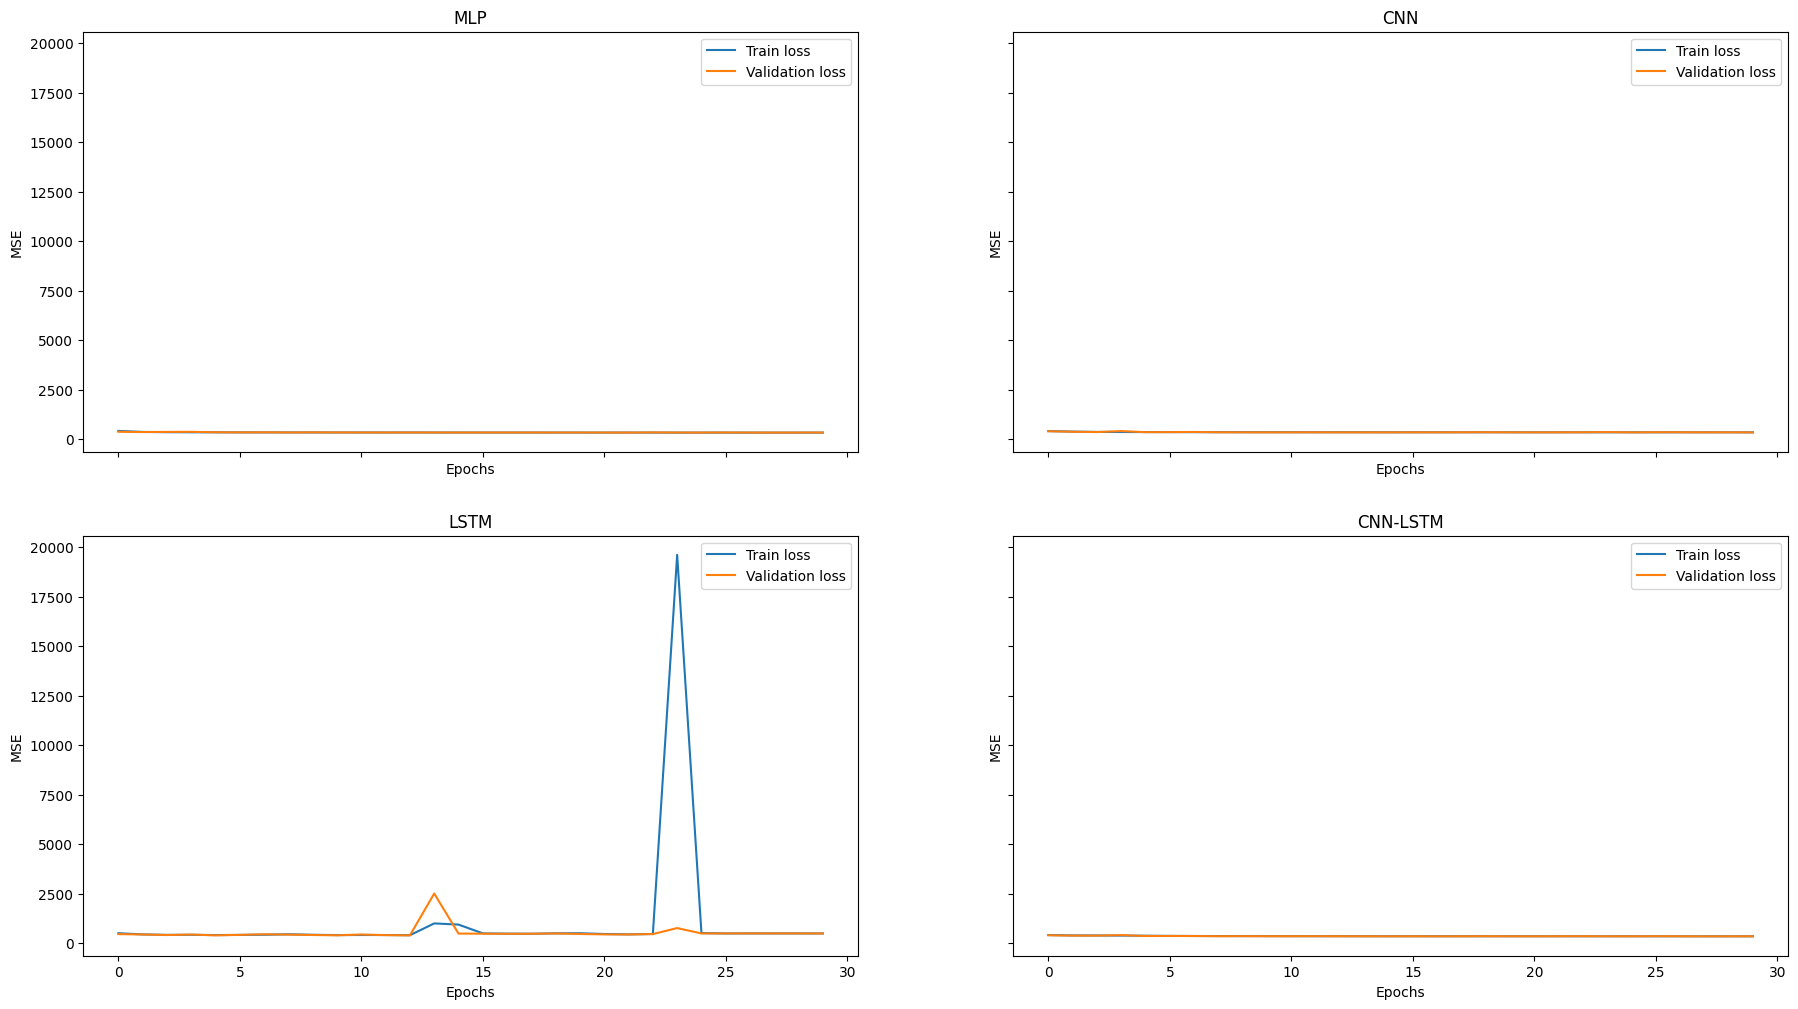

In [ ]:
fig, axes = plt.subplots(2, 2, sharex=True, sharey=True, figsize=(22,12))
ax1, ax2 = axes[0]
ax3, ax4 = axes[1]

ax1.plot(mlp_history.history['loss'], label='Train loss')
ax1.plot(mlp_history.history['val_loss'], label='Validation loss')
ax1.legend(loc='best')
ax1.set_title('MLP')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('MSE')

ax2.plot(cnn_history.history['loss'], label='Train loss')
ax2.plot(cnn_history.history['val_loss'], label='Validation loss')
ax2.legend(loc='best')
ax2.set_title('CNN')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('MSE')

ax3.plot(lstm_history.history['loss'], label='Train loss')
ax3.plot(lstm_history.history['val_loss'], label='Validation loss')
ax3.legend(loc='best')
ax3.set_title('LSTM')
ax3.set_xlabel('Epochs')
ax3.set_ylabel('MSE')

ax4.plot(cnn_lstm_history.history['loss'], label='Train loss')
ax4.plot(cnn_lstm_history.history['val_loss'], label='Validation loss')
ax4.legend(loc='best')
ax4.set_title('CNN-LSTM')
ax4.set_xlabel('Epochs')
ax4.set_ylabel('MSE')

plt.show()

## MLP on train and validation

In [ ]:
mlp_train_pred = model_mlp.predict(X_train.values)
mlp_valid_pred = model_mlp.predict(X_valid.values)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, mlp_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, mlp_valid_pred)))

2099/2099 [==============================] - 3s 2ms/step
Train rmse: 18.478555949965035
Validation rmse: 18.609182052112537


## CNN on train and validation

In [ ]:
cnn_train_pred = model_cnn.predict(X_train_series)
cnn_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_valid_pred)))

2099/2099 [==============================] - 4s 2ms/step
Train rmse: 18.697372226608636
Validation rmse: 18.760144475023196


## LSTM on train and validation

In [ ]:
lstm_train_pred = model_lstm.predict(X_train_series)
lstm_valid_pred = model_cnn.predict(X_valid_series)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, lstm_valid_pred)))

2099/2099 [==============================] - 5s 2ms/step
Train rmse: 22.340030684895318
Validation rmse: 18.760144475023196


## CNN-LSTM on train and validation

In [ ]:
cnn_lstm_train_pred = model_cnn_lstm.predict(X_train_series_sub)
cnn_lstm_valid_pred = model_cnn_lstm.predict(X_valid_series_sub)
print('Train rmse:', np.sqrt(mean_squared_error(Y_train, cnn_lstm_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(Y_valid, cnn_lstm_valid_pred)))

2099/2099 [==============================] - 5s 3ms/step
Train rmse: 18.89739770580109
Validation rmse: 18.924022243104343
